## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/16000_pcm_speeches.zip" -d "/content/drive/MyDrive/Speech/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/707.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/708.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/709.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/71.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/710.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/711.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/712.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/713.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/714.wav  
  inflating: /content/drive/MyDrive/Speech/16000_pcm_speeches/Benjamin_Netanyau/715.wav  
  inflating: /content/drive/MyDrive/Speech/16000_p

In [ ]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

DATASET_ROOT = "/content/drive/MyDrive/Speech/16000_pcm_speeches"

# The folders in which we will put the audio samples and the noise samples
AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "noise"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

# The sampling rate to use.
# This is the one used in all of the audio samples.
# We will resample all of the noise to this sampling rate.
# This will also be the output size of the audio wave samples
# (since all samples are of 1 second long)
SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:
#   noisy_sample = sample + noise * prop * scale
#      where prop = sample_amplitude / noise_amplitude
SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 100


In [ ]:
import scipy
import matplotlib.pyplot as plt
import librosa
def fft_plot(audio, sampling_rate):
  n = len(audio)
  T = 1/sampling_rate
  yf = scipy.fft.fft(audio)
  xf = np.linspace(0.0, 1.0//(2.0*T), n//2)
  fig, ax = plt.subplots()
  ax.plot(xf, 2.0/n * np.abs(yf[:n//2]))
  plt.grid()
  plt.xlabel("Frequency -->")
  plt.ylabel("Magnitude")
  return plt.show()

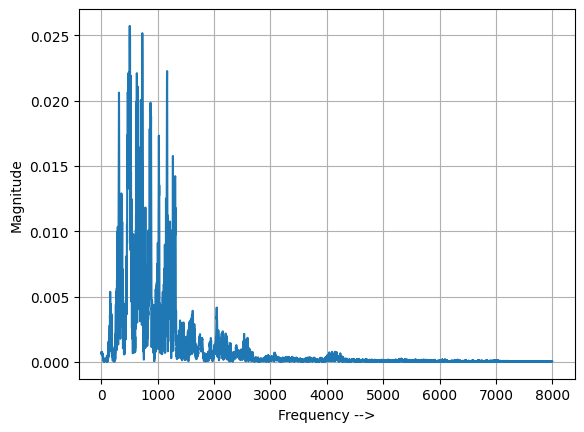

(array([-6.7324829e-01, -6.6809082e-01, -5.6985474e-01, ...,
        -5.1879883e-04, -6.1035156e-04, -8.2397461e-04], dtype=float32),
 16000)

In [ ]:
samples, sampling_rate = librosa.load("/content/drive/MyDrive/Speech/16000_pcm_speeches/audio/Anuj/102_test2.wav", sr = None, mono = True, offset = 0.0, duration = None)
fft_plot(samples, sampling_rate)
samples, sampling_rate

## Data preparation

The dataset is composed of 7 folders, divided into 2 groups:

- Speech samples, with 5 folders for 5 different speakers. Each folder contains
1500 audio files, each 1 second long and sampled at 16000 Hz.
- Background noise samples, with 2 folders and a total of 6 files. These files
are longer than 1 second (and originally not sampled at 16000 Hz, but we will resample them to 16000 Hz).
We will use those 6 files to create 354 1-second-long noise samples to be used for training.

Let's sort these 2 categories into 2 folders:

- An `audio` folder which will contain all the per-speaker speech sample folders
- A `noise` folder which will contain all the noise samples

Before sorting the audio and noise categories into 2 folders,
we have the following directory structure:

```
main_directory/
...speaker_a/
...speaker_b/
...speaker_c/
...speaker_d/
...speaker_e/
...other/
..._background_noise_/
```

After sorting, we end up with the following structure:

```
main_directory/
...audio/
......speaker_a/
......speaker_b/
......speaker_c/
......speaker_d/
......speaker_e/
...noise/
......other/
......_background_noise_/
```

In [ ]:
# If folder `audio`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_AUDIO_PATH) is False:
    os.makedirs(DATASET_AUDIO_PATH)

# If folder `noise`, does not exist, create it, otherwise do nothing
if os.path.exists(DATASET_NOISE_PATH) is False:
    os.makedirs(DATASET_NOISE_PATH)

for folder in os.listdir(DATASET_ROOT):
    if os.path.isdir(os.path.join(DATASET_ROOT, folder)):
        if folder in [AUDIO_SUBFOLDER, NOISE_SUBFOLDER]:
            # If folder is `audio` or `noise`, do nothing
            continue
        elif folder in ["other", "_background_noise_"]:
            # If folder is one of the folders that contains noise samples,
            # move it to the `noise` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_NOISE_PATH, folder),
            )
        else:
            # Otherwise, it should be a speaker folder, then move it to
            # `audio` folder
            shutil.move(
                os.path.join(DATASET_ROOT, folder),
                os.path.join(DATASET_AUDIO_PATH, folder),
            )

## Noise preparation

In this section:

- We load all noise samples (which should have been resampled to 16000)
- We split those noise samples to chuncks of 16000 samples which
correspond to 1 second duration each

In [ ]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


Resample all noise samples to 16000 Hz

In [ ]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

# Split noise into chunks of 16,000 steps each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


## Dataset generation

In [ ]:

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Anuj', 'Benjamin_Netanyau', 'Gaurav', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Rishita']
Processing speaker Anuj
Processing speaker Benjamin_Netanyau
Processing speaker Gaurav
Processing speaker Jens_Stoltenberg
Processing speaker Magaret_Tarcher
Processing speaker Rishita
Found 6831 files belonging to 6 classes.
Using 6148 files for training.
Using 683 files for validation.


In [ ]:
test_audio_paths = audio_paths
test_labels = labels

## Model Definition

In [ ]:

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8000, 1)]    0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 8000, 16)     64          ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, 8000, 16)     0           ['conv1d_1[0][0]']               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 8000, 16)     784         ['activation[0][0]']             
                                                                                              

## Training

In [ ]:
history = model.fit(
    train_ds,
    epochs=27,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/27
49/49 [==============================] - 47s 648ms/step - loss: 1.0692 - accuracy: 0.6973 - val_loss: 0.3550 - val_accuracy: 0.8741
Epoch 2/27
49/49 [==============================] - 32s 615ms/step - loss: 0.3357 - accuracy: 0.8811 - val_loss: 0.2187 - val_accuracy: 0.9356
Epoch 3/27
49/49 [==============================] - 35s 680ms/step - loss: 0.2666 - accuracy: 0.9060 - val_loss: 0.2974 - val_accuracy: 0.8829
Epoch 4/27
49/49 [==============================] - 32s 613ms/step - loss: 0.2334 - accuracy: 0.9161 - val_loss: 0.1851 - val_accuracy: 0.9341
Epoch 5/27
49/49 [==============================] - 32s 624ms/step - loss: 0.2059 - accuracy: 0.9283 - val_loss: 0.1702 - val_accuracy: 0.9429
Epoch 6/27
49/49 [==============================] - 32s 613ms/step - loss: 0.1783 - accuracy: 0.9351 - val_loss: 0.1738 - val_accuracy: 0.9400
Epoch 7/27
49/49 [==============================] - 33s 619ms/step - loss: 0.1838 - accuracy: 0.9374 - val_loss: 0.1220 - val_accuracy: 0.9634

## Evaluation

In [ ]:
print(model.evaluate(valid_ds))

22/22 [==============================] - 3s 105ms/step - loss: 0.0627 - accuracy: 0.9824
[0.06273758411407471, 0.9824304580688477]


We get ~ 98% validation accuracy.

In [ ]:
model.save('/content/drive/MyDrive/Speech/my_model.h5')

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Speech/my_model.h5")

## Demonstration

Let's take some samples and:

- Predict the speaker
- Compare the prediction with the real speaker
- Listen to the audio to see that despite the samples being noisy,
the model is still pretty accurate

In [ ]:
test_audio_paths = audio_paths
test_labels = labels

In [ ]:
label = ['Anuj', 'Benjamin_Netanyau', 'Gaurav', 'Jens_Stoltenberg', 'Magaret_Tarcher', 'Rishita']

In [ ]:
SAMPLES_TO_DISPLAY = 1

test_ds = paths_and_labels_to_dataset(test_audio_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

#test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    print(audios)
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    y_pred = label[np.argmax(y_pred)]
    print(y_pred)
    # Take random samples
    # rnd = 0#np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    # audios = audios.numpy()[rnd, :, :]
    # labels = labels.numpy()[rnd]
    # y_pred = np.argmax(y_pred, axis=-1)[rnd]

    # for index in range(SAMPLES_TO_DISPLAY):
    #     # For every sample, print the true and predicted label
    #     # as well as run the voice with the noise
    #     print(
    #         "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
    #             "[92m" if labels[index] == y_pred[index] else "[91m",
    #             class_names[labels[index]],
    #             "[92m" if labels[index] == y_pred[index] else "[91m",
    #             class_names[y_pred[index]],
    #         )
    #     )
    #     display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

tf.Tensor(
[[[ 0.00360107]
  [-0.0017395 ]
  [-0.0100708 ]
  ...
  [-0.103302  ]
  [-0.10073853]
  [-0.11636353]]], shape=(1, 16000, 1), dtype=float32)
1/1 [==============================] - 0s 22ms/step
b
